In [2]:
import os
from scipy.io import loadmat
import h5py

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load mat file data
mat = h5py.File(os.path.join("NYUv2", "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)

# Images are in 4D array (1449, 3, 640, 480), and depth maps are in 3D array (1449, 640, 480).
# We can simply transpose the axes to get them in a format suitable for training.

images = np.transpose(mat["images"], (0, 2, 3, 1))
depths = np.transpose(mat["depths"], (0, 2, 1))

# Shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
depths = depths[indices]

# Split data into training and validation
train_images = images[:1000]
train_depths = depths[:1000]
val_images = images[1000:]
val_depths = depths[1000:]

train_depths = np.transpose(train_depths, (0, 2, 1))
val_depths = np.transpose(val_depths, (0, 2, 1))

In [3]:
def crop_images(images, percentage):
    # The percentage should be between 0 and 1
    height, width = images.shape[1], images.shape[2]
    start_row = int(height * percentage / 2)
    end_row = height - start_row
    start_col = int(width * percentage / 2)
    end_col = width - start_col
    return images[:, start_row:end_row, start_col:end_col, :]

def crop_depth(images, percentage):
    # The percentage should be between 0 and 1
    height, width = images.shape[1], images.shape[2]
    start_row = int(height * percentage / 2)
    end_row = height - start_row
    start_col = int(width * percentage / 2)
    end_col = width - start_col
    return images[:, start_row:end_row, start_col:end_col]

percentage = 0.10  

# Crop training images
train_images = crop_images(train_images, percentage)
val_images = crop_images(val_images, percentage)

train_depths = crop_depth(train_depths, percentage)
val_depths = crop_depth(val_depths, percentage)

In [4]:
print(val_images.shape)

(449, 576, 432, 3)


In [5]:
print(train_depths.shape)

(1000, 576, 432)


In [6]:
margin = 70

# Extract depth value at the center and towards the corners
center_depths_train = train_depths[:, 288, 216]
corner1_depths_train = train_depths[:, margin, margin] 
corner2_depths_train = train_depths[:, margin, -margin] 
corner3_depths_train = train_depths[:, -margin, margin] 
corner4_depths_train = train_depths[:, -margin, -margin]

center_depths_val = val_depths[:, 288, 216]
corner1_depths_val = val_depths[:, margin, margin]
corner2_depths_val = val_depths[:, margin, -margin]
corner3_depths_val = val_depths[:, -margin, margin]
corner4_depths_val = val_depths[:, -margin, -margin]

# Reshape depths for suitable training 
center_depths_train = center_depths_train.reshape(-1, 1)
corner1_depths_train = corner1_depths_train.reshape(-1, 1)
corner2_depths_train = corner2_depths_train.reshape(-1, 1)
corner3_depths_train = corner3_depths_train.reshape(-1, 1)
corner4_depths_train = corner4_depths_train.reshape(-1, 1)

center_depths_val = center_depths_val.reshape(-1, 1)
corner1_depths_val = corner1_depths_val.reshape(-1, 1)
corner2_depths_val = corner2_depths_val.reshape(-1, 1)
corner3_depths_val = corner3_depths_val.reshape(-1, 1)
corner4_depths_val = corner4_depths_val.reshape(-1, 1)

# normalize images for better network performance
train_images = train_images / 255.
val_images = val_images / 255.


In [6]:
from tensorflow.keras.applications import VGG16

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers

def create_multi_task_model():
    vgg = VGG16(weights="imagenet", include_top=False, input_shape=(576, 432, 3))
    vgg.trainable = False

    model = Sequential()
    model.add(vgg)
    model.add(Flatten())

    # shared layer
    shared = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1))(model.output)

    # output layers for each task
    output_center = Dense(1, name="center_depth")(shared)
    output_corner1 = Dense(1, name="corner1_depth")(shared)
    output_corner2 = Dense(1, name="corner2_depth")(shared)
    output_corner3 = Dense(1, name="corner3_depth")(shared)
    output_corner4 = Dense(1, name="corner4_depth")(shared)

    # revised model for multi-task learning
    multi_task_model = tf.keras.Model(inputs=model.input, outputs=[output_center, output_corner1, output_corner2, output_corner3, output_corner4])

    return multi_task_model

In [7]:
# Now define your model using the multi-task function you created earlier
model = create_multi_task_model()

# compile the model
model.compile(optimizer='adam', 
              loss={'center_depth': 'mse', 
                    'corner1_depth': 'mse', 
                    'corner2_depth': 'mse', 
                    'corner3_depth': 'mse', 
                    'corner4_depth': 'mse'})

history = model.fit(train_images, 
                    {'center_depth': center_depths_train, 
                     'corner1_depth': corner1_depths_train, 
                     'corner2_depth': corner2_depths_train, 
                     'corner3_depth': corner3_depths_train, 
                     'corner4_depth': corner4_depths_train},
                    validation_data=(val_images, 
                                     {'center_depth': center_depths_val, 
                                      'corner1_depth': corner1_depths_val, 
                                      'corner2_depth': corner2_depths_val, 
                                      'corner3_depth': corner3_depths_val, 
                                      'corner4_depth': corner4_depths_val}),
                    epochs=80, 
                    batch_size=16)

Epoch 1/80
63/63 [==============================] - 22s 233ms/step - loss: 131.4318 - center_depth_loss: 30.7573 - corner1_depth_loss: 17.7575 - corner2_depth_loss: 13.3622 - corner3_depth_loss: 31.4595 - corner4_depth_loss: 15.3742 - val_loss: 27.1867 - val_center_depth_loss: 1.5559 - val_corner1_depth_loss: 2.1052 - val_corner2_depth_loss: 1.4842 - val_corner3_depth_loss: 2.1859 - val_corner4_depth_loss: 0.5946
Epoch 2/80
63/63 [==============================] - 11s 177ms/step - loss: 20.7371 - center_depth_loss: 1.0409 - corner1_depth_loss: 1.5334 - corner2_depth_loss: 0.7860 - corner3_depth_loss: 1.2281 - corner4_depth_loss: 0.5171 - val_loss: 19.8224 - val_center_depth_loss: 1.5342 - val_corner1_depth_loss: 2.0088 - val_corner2_depth_loss: 0.5190 - val_corner3_depth_loss: 2.4581 - val_corner4_depth_loss: 0.5631
Epoch 3/80
63/63 [==============================] - 11s 178ms/step - loss: 14.5014 - center_depth_loss: 0.7390 - corner1_depth_loss: 1.2278 - corner2_depth_loss: 0.4420 - c

Epoch 21/80
63/63 [==============================] - 12s 186ms/step - loss: 4.2297 - center_depth_loss: 0.7314 - corner1_depth_loss: 0.4827 - corner2_depth_loss: 0.4856 - corner3_depth_loss: 0.4229 - corner4_depth_loss: 0.2119 - val_loss: 8.8647 - val_center_depth_loss: 1.9018 - val_corner1_depth_loss: 2.0268 - val_corner2_depth_loss: 0.6839 - val_corner3_depth_loss: 1.7710 - val_corner4_depth_loss: 0.5803
Epoch 22/80
63/63 [==============================] - 12s 190ms/step - loss: 4.0921 - center_depth_loss: 0.6592 - corner1_depth_loss: 0.4034 - corner2_depth_loss: 0.4648 - corner3_depth_loss: 0.5056 - corner4_depth_loss: 0.2103 - val_loss: 8.1801 - val_center_depth_loss: 1.4124 - val_corner1_depth_loss: 1.8485 - val_corner2_depth_loss: 0.5581 - val_corner3_depth_loss: 1.8632 - val_corner4_depth_loss: 0.6720
Epoch 23/80
63/63 [==============================] - 12s 190ms/step - loss: 4.1911 - center_depth_loss: 0.5320 - corner1_depth_loss: 0.5591 - corner2_depth_loss: 0.4578 - corner3_d

Epoch 41/80
63/63 [==============================] - 12s 187ms/step - loss: 3.6212 - center_depth_loss: 0.4020 - corner1_depth_loss: 0.6542 - corner2_depth_loss: 0.4881 - corner3_depth_loss: 0.3966 - corner4_depth_loss: 0.2231 - val_loss: 7.6903 - val_center_depth_loss: 1.4027 - val_corner1_depth_loss: 1.9426 - val_corner2_depth_loss: 0.5592 - val_corner3_depth_loss: 1.6841 - val_corner4_depth_loss: 0.5226
Epoch 42/80
63/63 [==============================] - 12s 185ms/step - loss: 4.0148 - center_depth_loss: 0.4768 - corner1_depth_loss: 0.7631 - corner2_depth_loss: 0.4735 - corner3_depth_loss: 0.4844 - corner4_depth_loss: 0.2032 - val_loss: 8.3181 - val_center_depth_loss: 1.4108 - val_corner1_depth_loss: 2.0484 - val_corner2_depth_loss: 0.5565 - val_corner3_depth_loss: 2.2219 - val_corner4_depth_loss: 0.4899
Epoch 43/80
63/63 [==============================] - 12s 189ms/step - loss: 3.7398 - center_depth_loss: 0.5166 - corner1_depth_loss: 0.5843 - corner2_depth_loss: 0.4654 - corner3_d

Epoch 61/80
63/63 [==============================] - 12s 184ms/step - loss: 3.0570 - center_depth_loss: 0.3674 - corner1_depth_loss: 0.3210 - corner2_depth_loss: 0.3772 - corner3_depth_loss: 0.3945 - corner4_depth_loss: 0.2401 - val_loss: 7.8432 - val_center_depth_loss: 1.4135 - val_corner1_depth_loss: 2.0417 - val_corner2_depth_loss: 0.7132 - val_corner3_depth_loss: 1.6779 - val_corner4_depth_loss: 0.6561
Epoch 62/80
63/63 [==============================] - 12s 184ms/step - loss: 3.4472 - center_depth_loss: 0.3993 - corner1_depth_loss: 0.4814 - corner2_depth_loss: 0.4306 - corner3_depth_loss: 0.4642 - corner4_depth_loss: 0.2472 - val_loss: 7.6093 - val_center_depth_loss: 1.3296 - val_corner1_depth_loss: 1.8434 - val_corner2_depth_loss: 0.5351 - val_corner3_depth_loss: 1.8212 - val_corner4_depth_loss: 0.5629
Epoch 63/80
63/63 [==============================] - 12s 184ms/step - loss: 3.4614 - center_depth_loss: 0.3670 - corner1_depth_loss: 0.5059 - corner2_depth_loss: 0.3870 - corner3_d

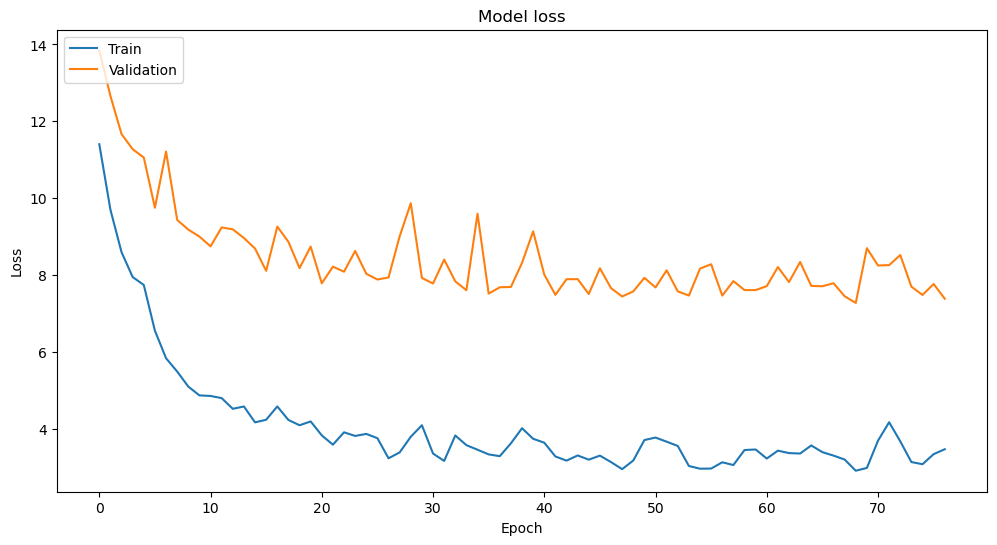

In [8]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model.save('distance_prediction_MultiClass.h5')

In [6]:
import tensorflow as tf

model = tf.keras.models.load_model('distance_prediction_MultiClass.h5')

In [7]:
#Fine-Tuning
from tensorflow.keras.optimizers import Adam

# Make all layers in the VGG16 model non-trainable
for layer in model.get_layer('vgg16').layers:
    layer.trainable = False

# Get the name of the last convolutional layer in VGG16
# In VGG16 architecture, it's usually 'block5_conv3'
last_conv_layer = 'block5_conv3'

# Set the last convolutional layer as trainable
model.get_layer('vgg16').get_layer(last_conv_layer).trainable = True


# Recompile the model for the changes to take effect
# We use a lower learning rate for fine-tuning
model.compile(optimizer=Adam(lr=1e-5), loss={'center_depth': 'mse', 
                    'corner1_depth': 'mse', 
                    'corner2_depth': 'mse', 
                    'corner3_depth': 'mse', 
                    'corner4_depth': 'mse'})

# Retrain the model
history = model.fit(train_images, 
                    {'center_depth': center_depths_train, 
                     'corner1_depth': corner1_depths_train, 
                     'corner2_depth': corner2_depths_train, 
                     'corner3_depth': corner3_depths_train, 
                     'corner4_depth': corner4_depths_train},
                    validation_data=(val_images, 
                                     {'center_depth': center_depths_val, 
                                      'corner1_depth': corner1_depths_val, 
                                      'corner2_depth': corner2_depths_val, 
                                      'corner3_depth': corner3_depths_val, 
                                      'corner4_depth': corner4_depths_val}),
                    epochs=30, 
                    batch_size=8)

C:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
125/125 [==============================] - 22s 128ms/step - loss: 4.1343 - center_depth_loss: 0.5694 - corner1_depth_loss: 0.7716 - corner2_depth_loss: 0.3598 - corner3_depth_loss: 0.7801 - corner4_depth_loss: 0.2567 - val_loss: 4.1358 - val_center_depth_loss: 0.5214 - val_corner1_depth_loss: 0.8283 - val_corner2_depth_loss: 0.4754 - val_corner3_depth_loss: 0.6501 - val_corner4_depth_loss: 0.2820
Epoch 2/30
125/125 [==============================] - 14s 112ms/step - loss: 3.8607 - center_depth_loss: 0.5156 - corner1_depth_loss: 0.6813 - corner2_depth_loss: 0.3514 - corner3_depth_loss: 0.7016 - corner4_depth_loss: 0.2464 - val_loss: 4.1437 - val_center_depth_loss: 0.5558 - val_corner1_depth_loss: 0.7856 - val_corner2_depth_loss: 0.4597 - val_corner3_depth_loss: 0.6979 - val_corner4_depth_loss: 0.2946
Epoch 3/30
125/125 [==============================] - 14s 112ms/step - loss: 3.6371 - center_depth_loss: 0.4655 - corner1_depth_loss: 0.6175 - corner2_depth_loss: 0.3457 - corner

Epoch 21/30
125/125 [==============================] - 15s 118ms/step - loss: 1.7278 - center_depth_loss: 0.0600 - corner1_depth_loss: 0.0773 - corner2_depth_loss: 0.2967 - corner3_depth_loss: 0.0887 - corner4_depth_loss: 0.1406 - val_loss: 3.8641 - val_center_depth_loss: 0.5451 - val_corner1_depth_loss: 0.7945 - val_corner2_depth_loss: 0.4606 - val_corner3_depth_loss: 0.7139 - val_corner4_depth_loss: 0.2922
Epoch 22/30
125/125 [==============================] - 15s 118ms/step - loss: 1.6907 - center_depth_loss: 0.0546 - corner1_depth_loss: 0.0702 - corner2_depth_loss: 0.2941 - corner3_depth_loss: 0.0803 - corner4_depth_loss: 0.1404 - val_loss: 3.8533 - val_center_depth_loss: 0.5525 - val_corner1_depth_loss: 0.7855 - val_corner2_depth_loss: 0.4621 - val_corner3_depth_loss: 0.7170 - val_corner4_depth_loss: 0.2918
Epoch 23/30
125/125 [==============================] - 15s 118ms/step - loss: 1.6533 - center_depth_loss: 0.0471 - corner1_depth_loss: 0.0628 - corner2_depth_loss: 0.2946 - cor

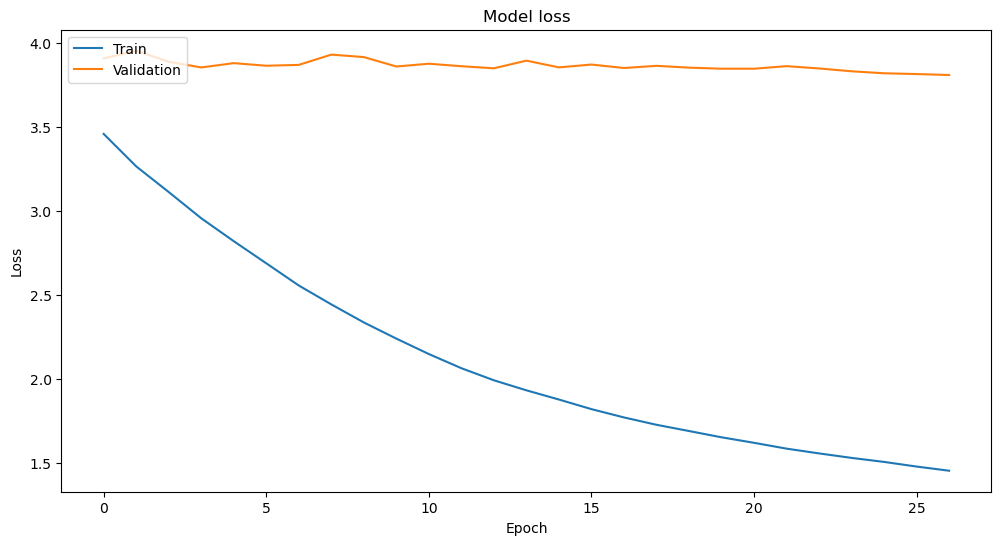

In [8]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
model.save('distance_prediction_MultiClass_fine_tuned.h5')

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('distance_prediction_MultiClass_fine_tuned.h5')

In [7]:
predicted_center_depths, predicted_corner1_depths, predicted_corner2_depths, predicted_corner3_depths, predicted_corner4_depths = model.predict(val_images[0:50])

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE and MSE for center depth
mae_center = mean_absolute_error(center_depths_val[0:50], predicted_center_depths[0:50])
mse_center = mean_squared_error(center_depths_val[0:50], predicted_center_depths[0:50])

# MAE and MSE for corner1 depth
mae_corner1 = mean_absolute_error(corner1_depths_val[0:50], predicted_corner1_depths[0:50])
mse_corner1 = mean_squared_error(corner1_depths_val[0:50], predicted_corner1_depths[0:50])

# MAE and MSE for corner2 depth
mae_corner2 = mean_absolute_error(corner2_depths_val[0:50], predicted_corner2_depths[0:50])
mse_corner2 = mean_squared_error(corner2_depths_val[0:50], predicted_corner2_depths[0:50])

# MAE and MSE for corner3 depth
mae_corner3 = mean_absolute_error(corner3_depths_val[0:50], predicted_corner3_depths[0:50])
mse_corner3 = mean_squared_error(corner3_depths_val[0:50], predicted_corner3_depths[0:50])

# MAE and MSE for corner4 depth
mae_corner4 = mean_absolute_error(corner4_depths_val[0:50], predicted_corner4_depths[0:50])
mse_corner4 = mean_squared_error(corner4_depths_val[0:50], predicted_corner4_depths[0:50])

# print the results
print("MAE for center depth:", mae_center)
print("MSE for center depth:", mse_center)

print("MAE for corner1 depth:", mae_corner1)
print("MSE for corner1 depth:", mse_corner1)

print("MAE for corner2 depth:", mae_corner2)
print("MSE for corner2 depth:", mse_corner2)

print("MAE for corner3 depth:", mae_corner3)
print("MSE for corner3 depth:", mse_corner3)

print("MAE for corner4 depth:", mae_corner4)
print("MSE for corner4 depth:", mse_corner4)


concat_true_depths = np.concatenate([center_depths_val[0:50], corner1_depths_val[0:50], corner2_depths_val[0:50], corner3_depths_val[0:50], corner4_depths_val[0:50]])
concat_predicted_depths = np.concatenate([predicted_center_depths, predicted_corner1_depths, predicted_corner2_depths, predicted_corner3_depths, predicted_corner4_depths])

# MAE and MSE for all depth
mae_all = mean_absolute_error(concat_true_depths, concat_predicted_depths)
mse_all = mean_squared_error(concat_true_depths, concat_predicted_depths)

print("Overall MAE:", mae_all)
print("Overall MSE:", mse_all)

2/2 [==============================] - 13s 4s/step
MAE for center depth: 0.14480862
MSE for center depth: 0.05134046
MAE for corner1 depth: 0.25127262
MSE for corner1 depth: 0.12259394
MAE for corner2 depth: 0.46345797
MSE for corner2 depth: 0.324741
MAE for corner3 depth: 0.27066246
MSE for corner3 depth: 0.14645758
MAE for corner4 depth: 0.3342276
MSE for corner4 depth: 0.17390312
Overall MAE: 0.29288587
Overall MSE: 0.16380721


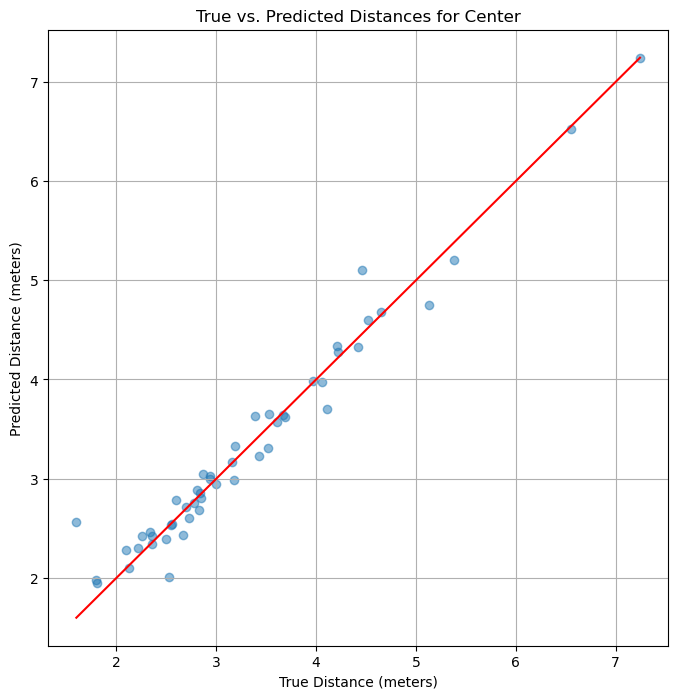

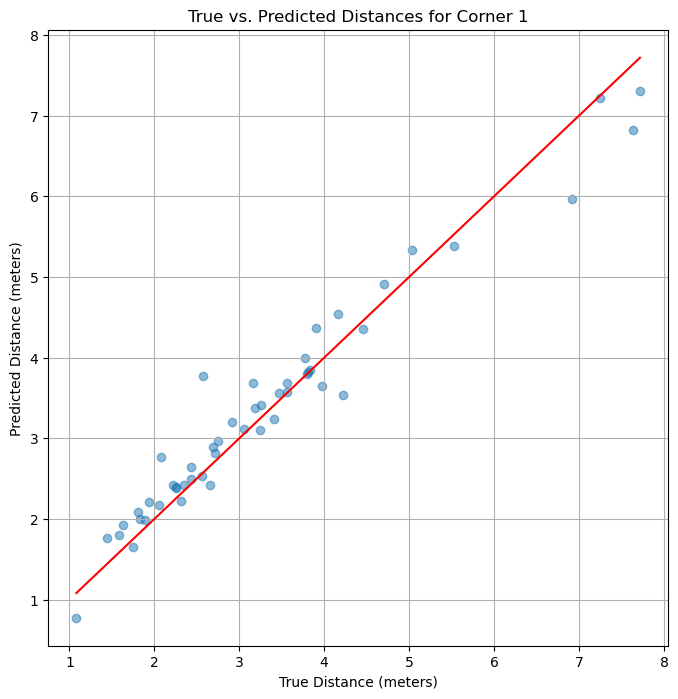

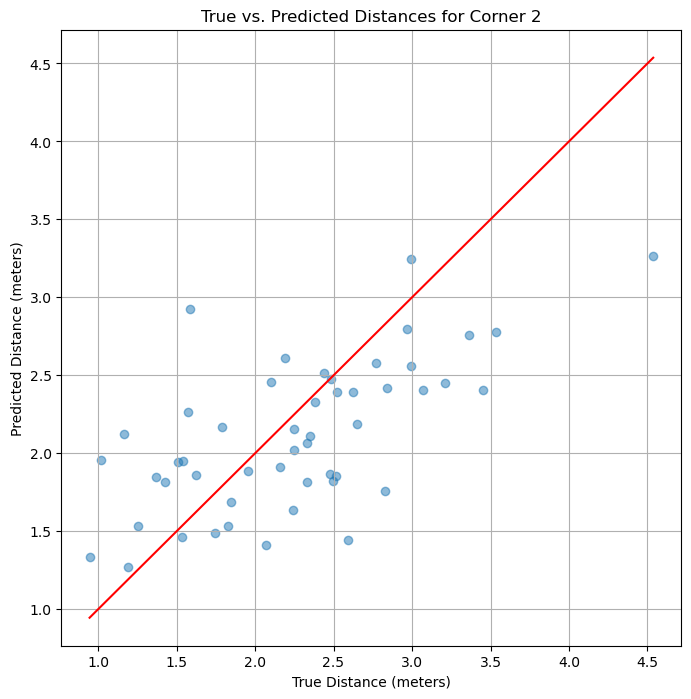

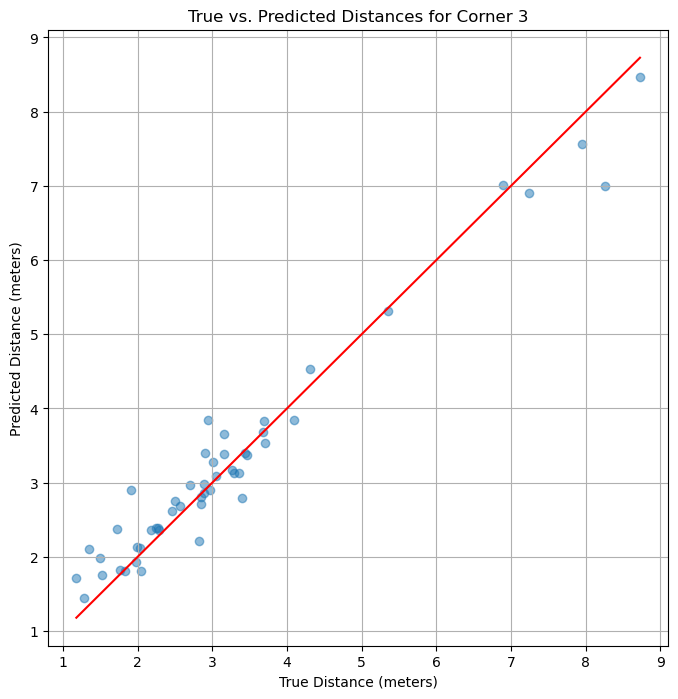

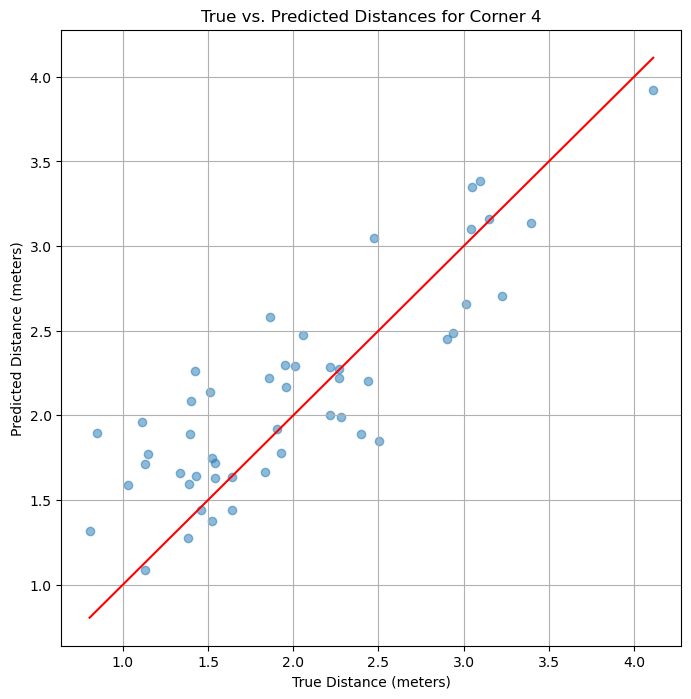

In [9]:
# Helper function to plot scatter
def scatter_plot(true_values, predicted_values, point_name):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.5)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red')  # Ideal model would follow this line
    plt.xlabel('True Distance (meters)')
    plt.ylabel('Predicted Distance (meters)')
    plt.title(f'True vs. Predicted Distances for {point_name}')
    plt.grid(True)
    plt.show()

# Scatter plot for center
scatter_plot(center_depths_val[0:50].flatten(), predicted_center_depths.flatten(), 'Center')

# Scatter plot for corner1
scatter_plot(corner1_depths_val[0:50].flatten(), predicted_corner1_depths.flatten(), 'Corner 1')

# Scatter plot for corner2
scatter_plot(corner2_depths_val[0:50].flatten(), predicted_corner2_depths.flatten(), 'Corner 2')

# Scatter plot for corner3
scatter_plot(corner3_depths_val[0:50].flatten(), predicted_corner3_depths.flatten(), 'Corner 3')

# Scatter plot for corner4
scatter_plot(corner4_depths_val[0:50].flatten(), predicted_corner4_depths.flatten(), 'Corner 4')

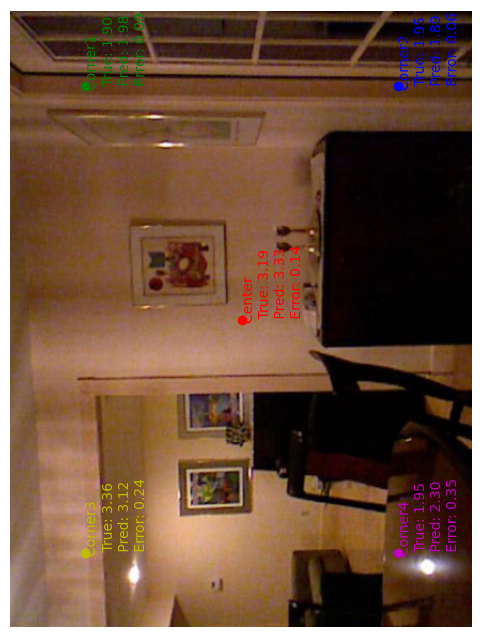

In [36]:
# Import required libraries
from matplotlib.patches import Circle
from scipy import ndimage

# Define a function to plot the image with depths
def plot_sample(index, images, true_depths, predicted_depths):
    plt.figure(figsize=(8, 8))

    # Plot image
    plt.imshow(images[index])

    # Define points for depth values
    points = [(216, 288), (margin, margin), (-margin, margin), (margin, -margin), (-margin, -margin)]
    names = ['Center', 'Corner1', 'Corner2', 'Corner3', 'Corner4']
    colors = ['r', 'g', 'b', 'y', 'm']

    for i, point in enumerate(points):
        x, y = point
        # Adjust points for negative values
        x = x if x >= 0 else images[index].shape[1] + x
        y = y if y >= 0 else images[index].shape[0] + y

        # Plot circle at the point
        plt.plot(x, y, 'o', color=colors[i])

        # Display true and predicted depths
        true_depth = true_depths[i][index]
        predicted_depth = predicted_depths[i][index]
        error = abs(true_depth - predicted_depth)
        plt.text(x, y, f'{names[i]} \n True: {true_depth[0]:.2f} \n Pred: {predicted_depth[0]:.2f} \n Error: {error[0]:.2f}', color=colors[i], rotation=90)

    plt.axis('off')
    plt.show()

# Use the function to plot a sample
plot_sample(1, val_images, 
            [center_depths_val, corner1_depths_val, corner2_depths_val, corner3_depths_val, corner4_depths_val],
            [predicted_center_depths, predicted_corner1_depths, predicted_corner2_depths, predicted_corner3_depths, predicted_corner4_depths])
